# i. BUSINESS JOB DESCRIPTION

*   Our Client is 'Top Bank', a Bank company that is looking forward to reduce its operational cost by preventing client churning.
*   Churning refers to the ammount of clients present in the current database whose contracts have expired, indicating they stopped buying products or signing deals with the company.
*   Since it is already well known that the cost of acquiring new clients are much higher than that of maintaining already existing ones, it is advantageous for Top Bank to gather information about what will lead a client towards the decising of leaving the company in order to prevent client churning.

# ii. THE CHALLENGE

*   We were hired as Data Science consultants, with the main goal to build a Machine Learning Model capable of classifying existing contracts into two classes to determine wheter a client will churn or not
*   Having the solution at hands, the company will be able to plan its strategy for reaching out the entries with churn occurance in order to keep their contracts active.
*   In order to undestand our clients behaviour, we initially have information about demographics(gender, age, geography) as well as information about their contracts which give us insights on their relationship with Top Bank (Tenure, Balance, Nº of Products, Credit Card, Account Situation, Estimated Salary)

# iii. BUSINESS QUESTIONS

*   What is the actual churn rate from Top Bank's dataset?
*   What is the Machine Learning model performance for classifiyng potential Churn clients on a given dataset?
*   What will be Top Bank's revenue if it manages to hold their clients from churning?

# 0.0 IMPORTS FUNCTIONS AND CONNECTION

## 0.1 Packages and Libraries

In [1]:
import pandas   as pd
import numpy    as np
import seaborn  as sns
import warnings
import inflection
import math

from matplotlib     import pyplot as plt
from scipy.stats    import chi2_contingency
from boruta         import BorutaPy

from sklearn.model_selection    import train_test_split
from sklearn.preprocessing      import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble           import ExtraTreesClassifier, RandomForestClassifier, RandomForestRegressor


from IPython.core.display   import HTML
from IPython.display        import Image

## 0.2 Helper Functions

In [2]:
warnings.filterwarnings ('ignore')

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

def cramerV(label,x):
    confusion_matrix = pd.crosstab(label, x)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r,k = confusion_matrix.shape
    phi2 = chi2/n
    phi2corr = max(0,phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r - 1) ** 2) / ( n - 1 )
    kcorr = k - ((k - 1) ** 2) / ( n - 1 )
    try:
        if min((kcorr - 1),(rcorr - 1)) == 0:
            warnings.warn(
            "Unable to calculate Cramer's V using bias correction. Consider not using bias correction",RuntimeWarning)
            v = 0
            print("If condition Met: ",v)
        else:
            v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
            print("Else condition Met: ",v)
    except:
        print("inside error")
        v = 0
    return v

def plot_cramer(df):
    cramer = pd.DataFrame(index=df.columns,columns=df.columns)
    for column_of_interest in df.columns:
        try:
            temp = {}

            columns = df.columns
            for j in range(0,len(columns)):
                v = cramerV(df[column_of_interest],df[columns[j]])
                cramer.loc[column_of_interest,columns[j]] = v
                if (column_of_interest==columns[j]):
                    pass
                else:
                    temp[columns[j]] = v
            cramer.fillna(value=np.nan,inplace=True)
        except:
            print('Dropping row:',column_of_interest)
            pass
    plt.figure(figsize=(7,7))
    sns.heatmap(cramer,annot=True,fmt='.2f')

    plt.title("Cross Correlation plot on Dataframe with Cramer's Correlation Values")
    plt.show()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.3 Database Load

In [4]:
df_raw = pd.read_csv('data/raw/churn.csv')
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 1.0 DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1 Data Dimensions

In [6]:
print(f'Número de Linhas: {df1.shape[0]}')
print(f'Número de Colunas: {df1.shape[1]}')

Número de Linhas: 10000
Número de Colunas: 14


## 1.2 Column Rename

In [7]:
cols_old = ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [8]:
df1.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 1.3 Data Type Definition

# 1.3.1. Column Description

*    row_number -> Corresponds to the record(row) number and has no effect on the output
*    customer_id -> random values used to diferentiate each entry
*    surname -> surname from the customer
*    credit_score -> score to a given customer credit score; can have an effect on customer churn given that higher scores might lead to a client being less likely to leave the bank
*    geography -> customer location; might have an impact on client churning
*    gender -> customer's gender
*    age -> customer's age
*    tenure -> refers to the number of years that the customer has been a client of the bank; might have an impact on churning given that older clients (high tenure values) might imply in higher loyalty to the bank's services.
*    balance -> customer's bank account balance
*    num_of_products -> refers to the number of products from the bank a client has used on contract
*    has_cr_card -> denotes wheter or not a client has a credit card
*    is_active_member -> denotes the status of a client contract 
*    estimated_salary -> client salary estimation; migh have an impact on client churning similar to the observed from 'balance' feature
*    exited -> class variable, indicates wheter a client has churned or not.

In [9]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

*   No need for data types formating.

## 1.4 Check NA

In [10]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

*   No further need for NaN/Null data treatment

## 1.5 Métricas de Descrição Geral dos dados

### 1.5.1 Numerical Data

In [11]:
df1_num = df1.select_dtypes(include=['int64', 'float64'])
df1_cat = df1.select_dtypes(exclude=['int64', 'float64'])

#Métricas de tendência central - média, mediana
ct1 = pd.DataFrame(df1_num.apply(np.mean)).T
ct2 = pd.DataFrame(df1_num.apply(np.median)).T

#Métricas de dispersão - min, max, range, desvio padrão (std) skew, kurtosis

d1 = pd.DataFrame(df1_num.apply(min)).T
d2 = pd.DataFrame(df1_num.apply(max)).T
d3 = pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(df1_num.apply(np.std)).T
d5 = pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T

df_desc = pd.concat([d1, d2, d3, ct1, ct2, d4, d5, d6]).T.reset_index().round(2)
df_desc.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
df_desc

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,row_number,1.00,10000.00,9999.00,5000.50,5000.50,2886.75,0.00,-1.20
1,customer_id,15565701.00,15815690.00,249989.00,15690940.57,15690738.00,71932.59,0.00,-1.20
2,credit_score,350.00,850.00,500.00,650.53,652.00,96.65,-0.07,-0.43
3,age,18.00,92.00,74.00,38.92,37.00,10.49,1.01,1.40
4,tenure,0.00,10.00,10.00,5.01,5.00,2.89,0.01,-1.17
5,balance,0.00,250898.09,250898.09,76485.89,97198.54,62394.29,-0.14,-1.49
6,num_of_products,1.00,4.00,3.00,1.53,1.00,0.58,0.75,0.58
7,has_cr_card,0.00,1.00,1.00,0.71,1.00,0.46,-0.90,-1.19
8,is_active_member,0.00,1.00,1.00,0.52,1.00,0.50,-0.06,-2.00
9,estimated_salary,11.58,199992.48,199980.90,100090.24,100193.92,57507.62,0.00,-1.18


From this general data overview, we can infer:

*   The average value for credit_score is 650.53, very close to its median value (652.00). The distribution is normal for this feature.
*   The average value for age is around 39 years, with a right skewed distribution (similar to normal).
*   The average value for has_cr_card is 0.71. Given that this is a binary feature, we can assume the majority of clients have the bank's credit card.
*   The average value for is_active_member is 0.52. For a binary feature, this indicates that almost half of the database are under contracts and bank accounts with low recency, indicating possible low rates for account usage.
*   The average value for our class variable ('exited') is 0.2. Given that this is a binary feature, this points out that we have an **unbalaced** dataset, having a much lower proportion of clients that have churned.

### 1.5.2 Categorical Data

In [12]:
df1_cat.apply(lambda x: x.unique().shape[0]) 

surname      2932
geography       3
gender          2
dtype: int64

In [13]:
df1[['row_number', 'surname']].groupby('surname').count().sort_values('row_number', ascending=False).reset_index().head()

,surname,row_number
0,Smith,32
1,Martin,29
2,Scott,29
3,Walker,28
4,Brown,26


*   The surname groupment indicates that we have different entries under the same surname registered.

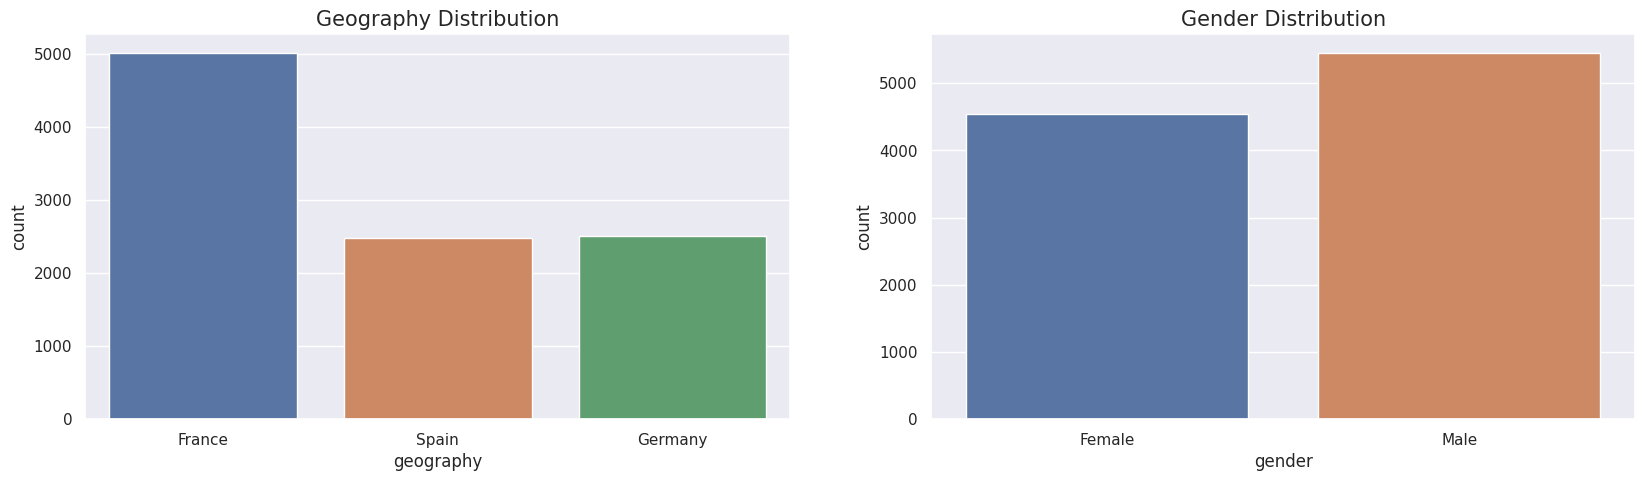

In [14]:
plt.figure(figsize=(20,5))
plt.subplot2grid((1,2), (0,0))
plt.subplot2grid((1,2), (0,1))

plt.subplot(1, 2, 1)
plt.title('Geography Distribution', fontsize=15)
sns.countplot(df1, x='geography');

plt.subplot(1, 2, 2)
plt.title('Gender Distribution', fontsize=15)
sns.countplot(df1, x='gender');

*   France shows to be the most prominent place with contracts on the dataset
*   The ratio between Male/Female is about 55/45, thus being a fairly balanced distribution.

# 2.0 Feature Engineering

In [15]:
df2 = df1.copy()

reorder_columns = ['row_number', 'customer_id', 'surname', 'geography',
       'gender', 'age','has_cr_card', 'credit_score', 'tenure', 'balance',
       'is_active_member', 'estimated_salary', 'num_of_products', 'exited']

df2 = df2.reindex(columns=reorder_columns)

In [16]:
df2.columns

Index(['row_number', 'customer_id', 'surname', 'geography', 'gender', 'age',
       'has_cr_card', 'credit_score', 'tenure', 'balance', 'is_active_member',
       'estimated_salary', 'num_of_products', 'exited'],
      dtype='object')

## 2.1 Mindmap de Hipóteses

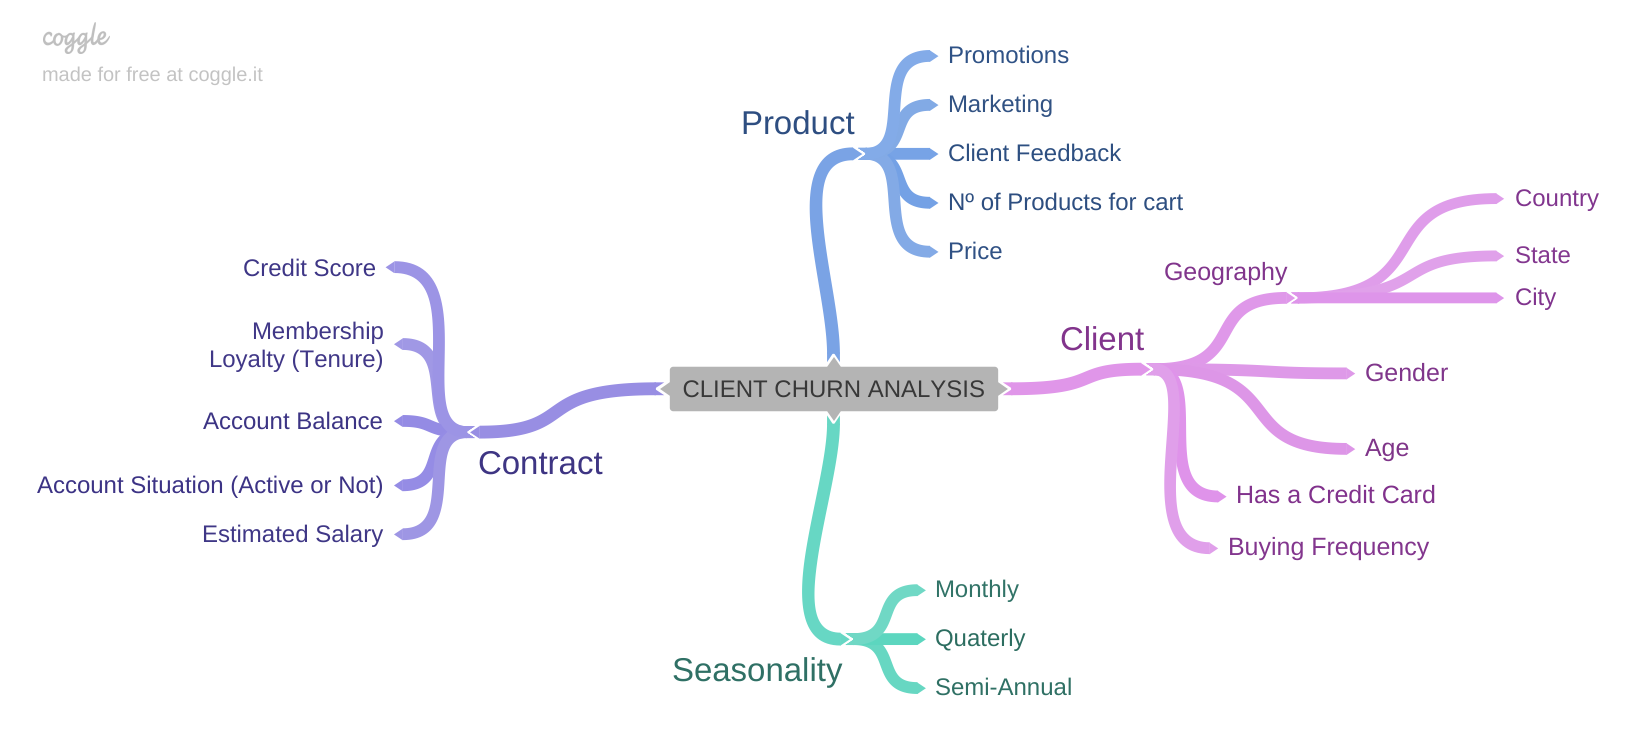

In [17]:
Image('img/churn_analysis_eng.png')

### 2.1.1  List of Client related   Hypothesis

    1.  Clients from a certain region are 10% more likely to churn
    2.  Clients from a given gender are 10% more likely to churn.
    3.  Older Clients can be 10% or higher likely to churn.
    4.  Clients who have the Top Bank's credit card are 10% less likely to churn.
    5.  Clients that buy more frequently are 10% less likely to churn.

### 2.1.2 List of Contract related Hypothesis

    1.  Contracts with higher credit scores are 10% less likely to churn.
    2.  Contracts with higher tenure values are 10% less likely to churn.
    3.  contracts with higher inbank account balances are 10% less likely to churn.
    4.  Contracts that present active situation under bank account movimentation are 10% less likely to churn.
    5.  Contracts with higher estimated values for client salaries are 10% less likely to churn.

### 2.1.3 List of Product related Hypothesis

    1. Frequent promotion exposure reduce up to 10% the chances of a client churn.
    2. Higher Client Satisfaction feedback reduce up to 10% the chances of a client churn.
    3. Contracts done with higher nº of used products tend to reduce up to 10% the chances of a client churn.
    4. More expensive products tend to be 10% more likely to be related with client churn.

### 2.1.4 List of Time related Hypothesis

    1. Clients tnd to churn up to 10% more under a determined seasonality (monthly/bimonthly/semi annual/etc).

## 2.2 Final List of Hypothesis

    1.  Clients from a certain region are 10% more likely to churn
    2.  Clients from a certain gender are 10% more likely to churn.
    3.  Older Clients can be 10% or higher likely to churn.
    4.  Clients who have the Top Bank's credit card are 10% less likely to churn.
    5.  Contracts with higher credit scores are 10% less likely to churn.
    6.  Contracts with higher tenure values are 10% less likely to churn.
    7.  Contracts with higher inbank account balances are 10% less likely to churn.
    8.  Contracts that present active situation under bank account movimentation are 10% less likely to churn.
    9.  Contracts with higher estimated values for client salaries are 10% less likely to churn.
    10. Contracts done with higher nº of used products tend to reduce up to 10% the chances of a client churn.
    

# 3.0 DATA RAZORING

In [18]:
df3 = df2.copy()

In [19]:
df3 = df3.drop(['surname', 'customer_id'], axis=1)

*   Identifier columns ('surname' and 'customer_id') were removed from the studied dataset since there is no information gain obtained from those features

In [20]:
df3.head()

,row_number,geography,gender,age,has_cr_card,credit_score,tenure,balance,is_active_member,estimated_salary,num_of_products,exited
0,1,France,Female,42,1,619,2,0.00,1,101348.88,1,1
1,2,Spain,Female,41,0,608,1,83807.86,1,112542.58,1,0
2,3,France,Female,42,1,502,8,159660.80,0,113931.57,3,1
3,4,France,Female,39,0,699,1,0.00,0,93826.63,2,0
4,5,Spain,Female,43,1,850,2,125510.82,1,79084.10,1,0


# 4.0 EXPLORATORY DATA ANALYSIS (EDA)

In [21]:
df4 = df3.copy()
df4_num = df4.select_dtypes(include=['int64', 'float64'])

## 4.1 Univariative Analysis

### 4.1.1 Numerical Variables

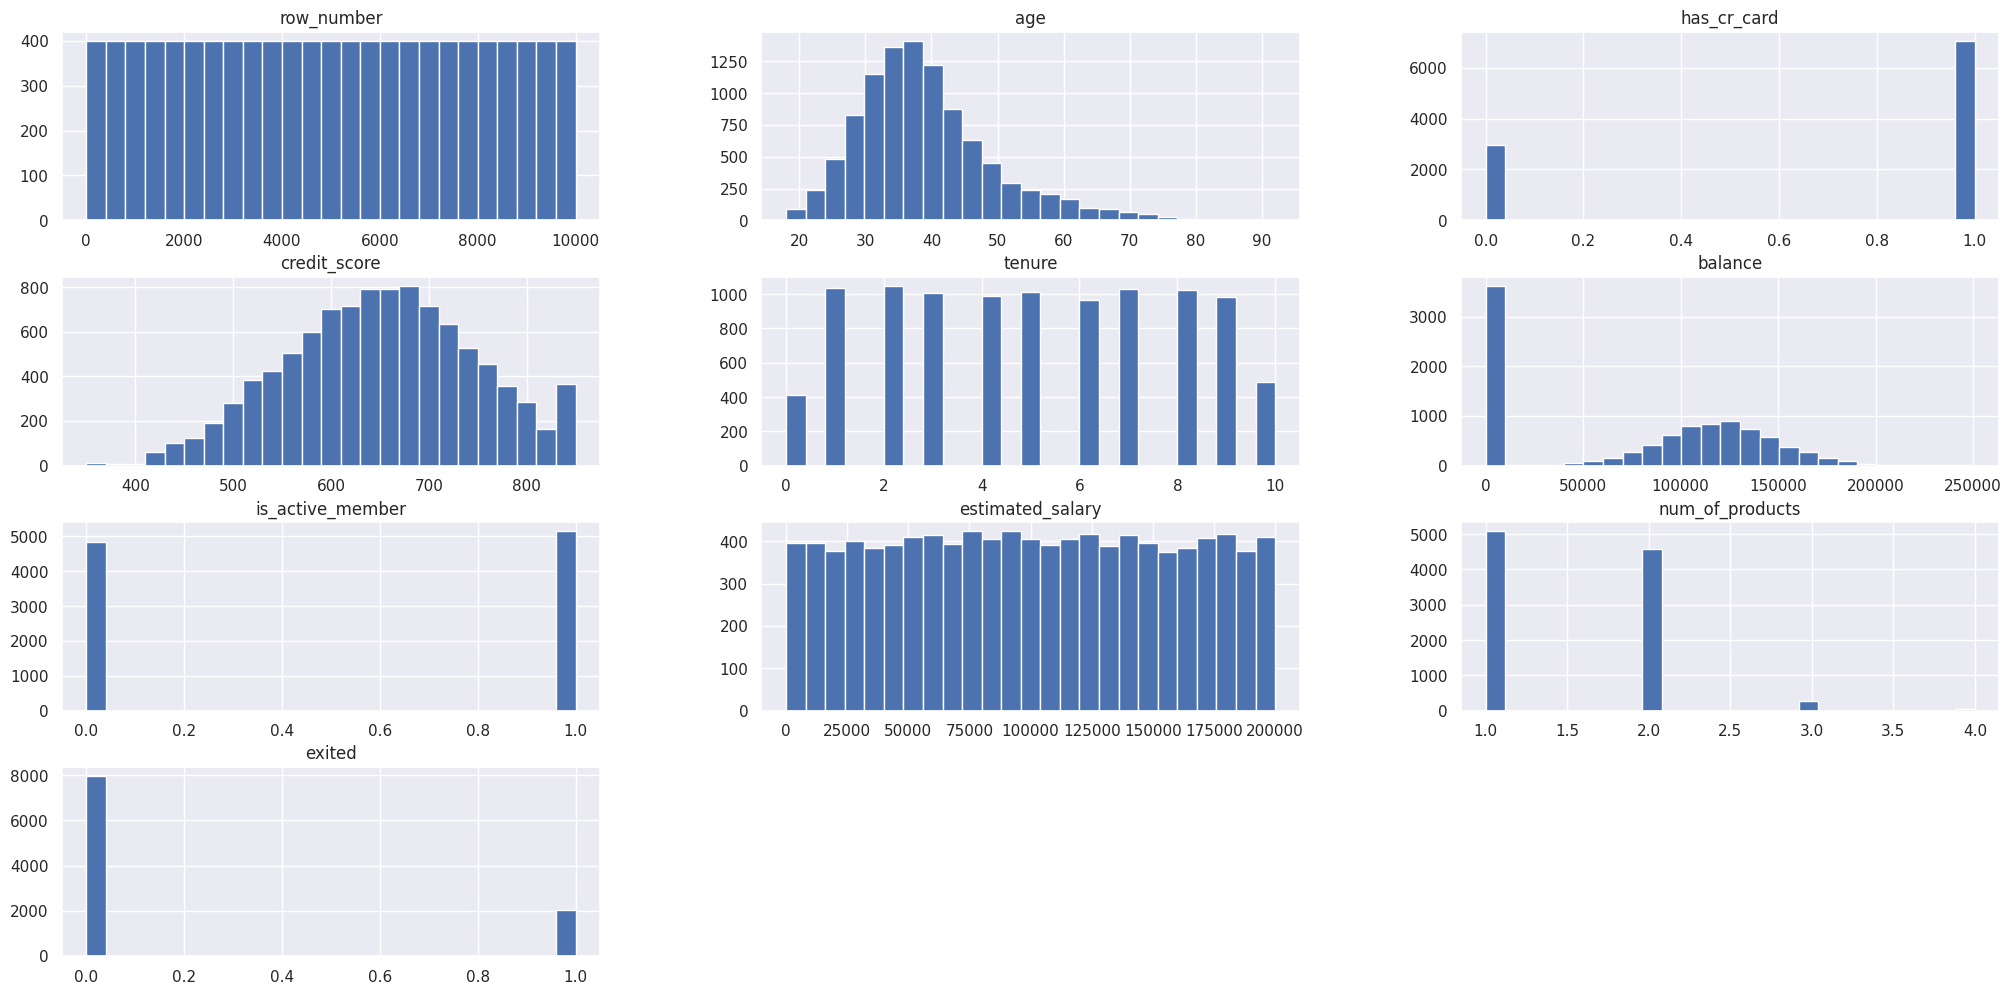

In [22]:
df4_num.hist(bins=25);  

*   Both 'Age' and 'credit_score' features present a distribution closer to a normal one, even tho they present light skew.
*   'Balance' feature presents a high count of entries with the value '0'. This can point us to inactive accounts that can lead us to churn correaltion. Other than that, the overall distribution is normal.
*    More importatly: Our class variable ('exited') presents a 4:1 ratio, indicating that we have an **unbalanced** dataset

### 4.1.2 Categorical Variables

In [23]:
df4['gender'].drop_duplicates()

0    Female
5      Male
Name: gender, dtype: object

In [24]:
df4['geography'].drop_duplicates()

0     France
1      Spain
7    Germany
Name: geography, dtype: object

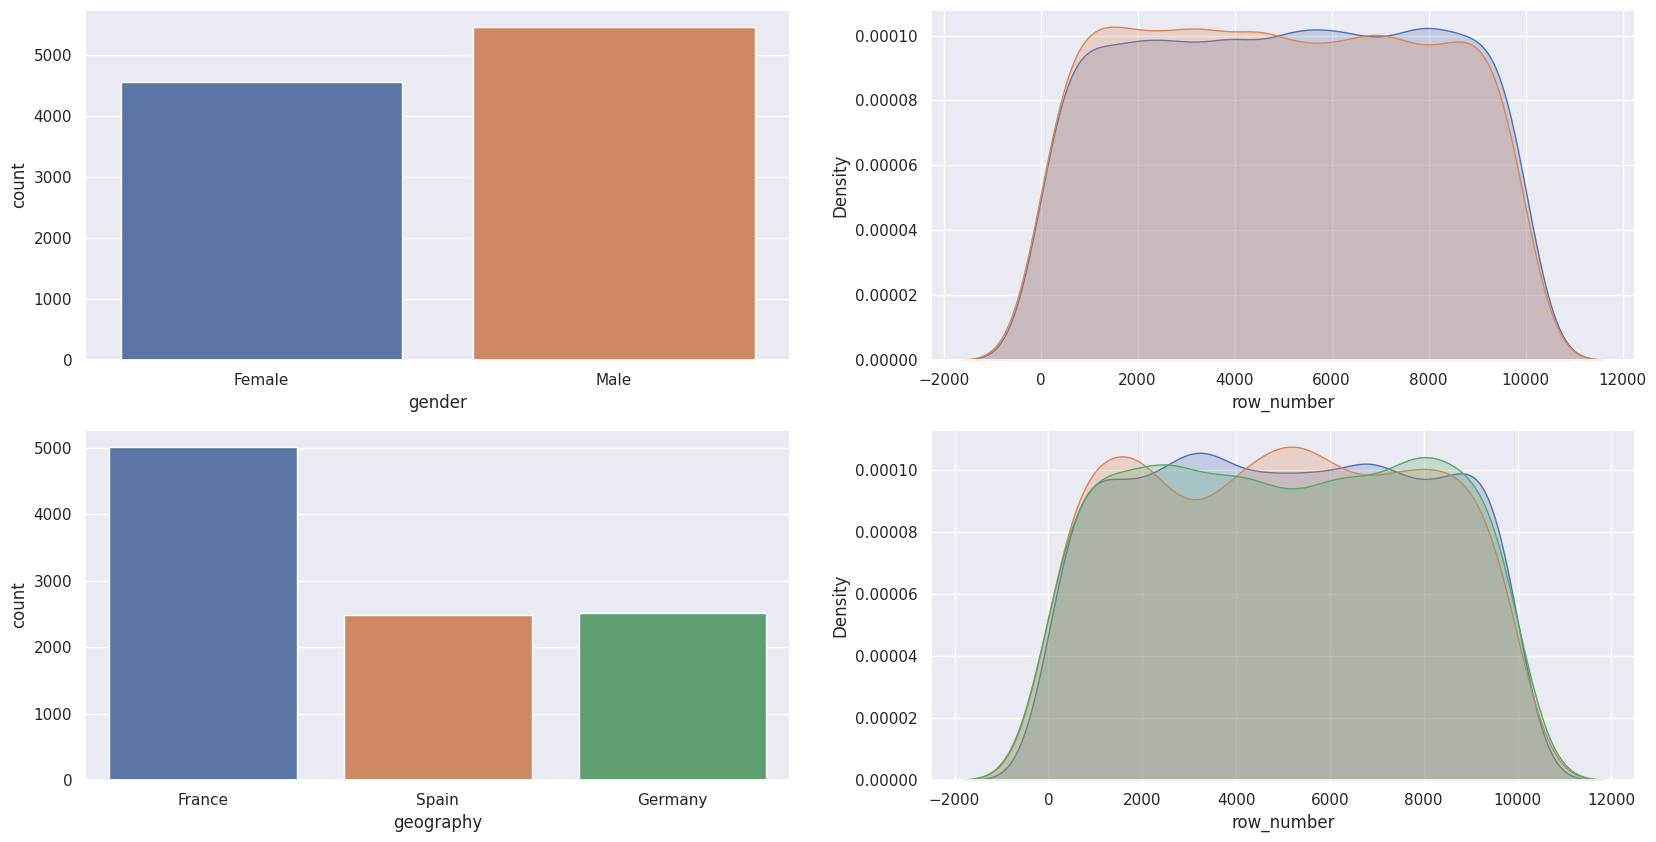

In [25]:
plt.figure(figsize=(20,10))
plt.subplot2grid((2,2), (0,0))
plt.subplot2grid((2,2), (0,1))
plt.subplot2grid((2,2), (1,0))
plt.subplot2grid((2,2), (1,1))

plt.subplot(2, 2, 1)
sns.countplot(df4, x='gender');
plt.subplot(2, 2, 2)
sns.kdeplot(df4[df4['gender'] == 'Male']['row_number'], label='Male', shade=True);
sns.kdeplot(df4[df4['gender'] == 'Female']['row_number'], label='Female', shade=True);

plt.subplot(2, 2, 3)
sns.countplot(df4, x='geography');
plt.subplot(2, 2, 4)
sns.kdeplot(df4[df4['geography'] == 'France']['row_number'], label='France', shade=True);
sns.kdeplot(df4[df4['geography'] == 'Spain']['row_number'], label='Spain', shade=True);
sns.kdeplot(df4[df4['geography'] == 'Germany']['row_number'], label='Germany', shade=True);

## 4.2 Bivariative Analysis

### 4.2.1 Exploratory Data Analysis(EDA)

### H1.Clients from a certain region are 10% more likely to churn    
    True -> German Clients are 10% more likely to churn compared to both the other countries (Spain and France)

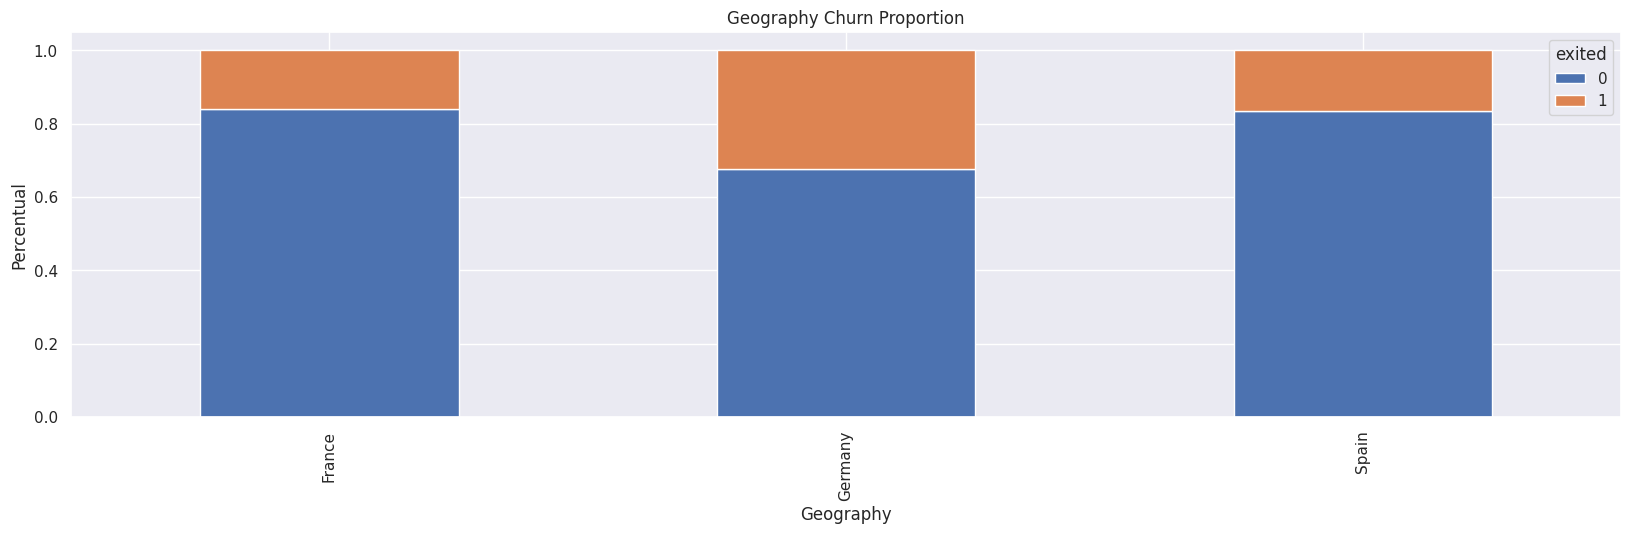

In [26]:
region_aux = pd.crosstab(df4['geography'], df4['exited']).apply(lambda x: x/x.sum(), axis=1)
region_aux.plot(kind='bar',stacked=True, xlabel = 'Geography', ylabel='Percentual', title='Geography Churn Proportion', figsize=(20,5));

### H2. Clients from a certain gender are 10% more likely to churn.
    True -> Women are aproximately 10% more likely to churn compared to men.

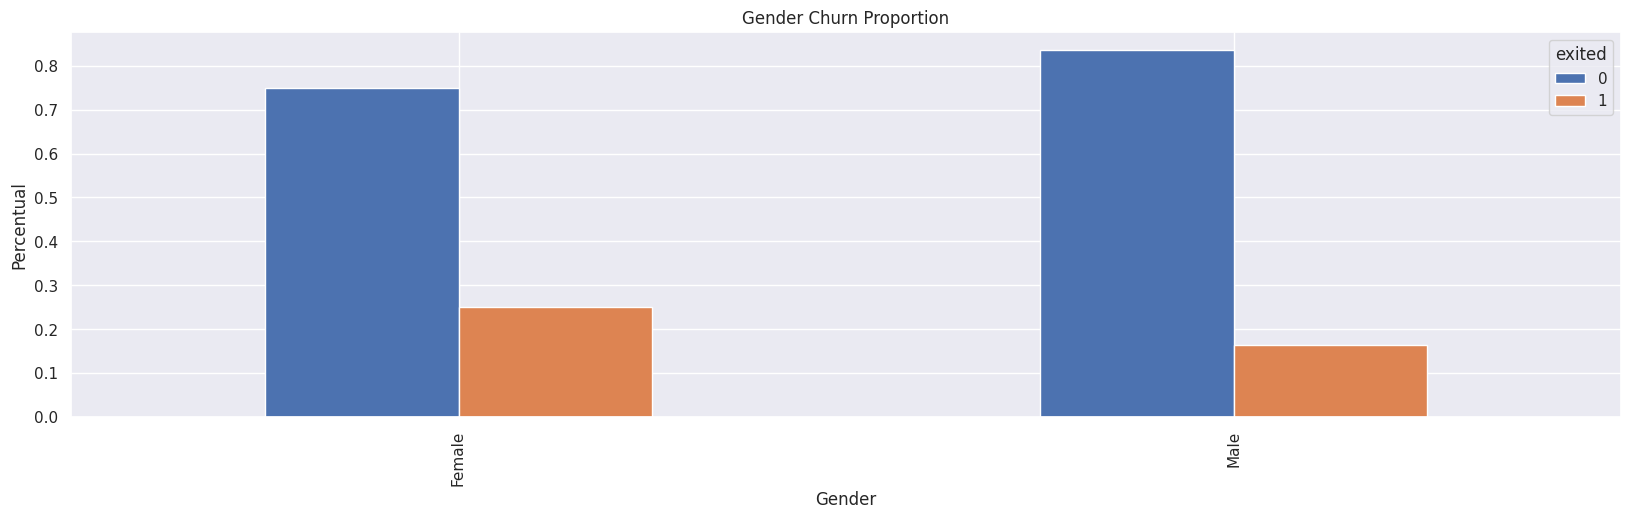

In [27]:


gender_aux = pd.crosstab(df4['gender'], df4['exited']).apply(lambda x: x/x.sum(), axis=1)
gender_aux.plot(kind='bar', stacked=False, xlabel='Gender', ylabel='Percentual', title='Gender Churn Proportion', figsize=(20,5));

### H3. Older Clients can be 10% or higher likely to churn.
    True -> Central Tendecy metrics (mean, median) are different between 'churn' and 'no churn' situation. Clients aged from 38 to 52 years old are the ones who are most likely to churn.

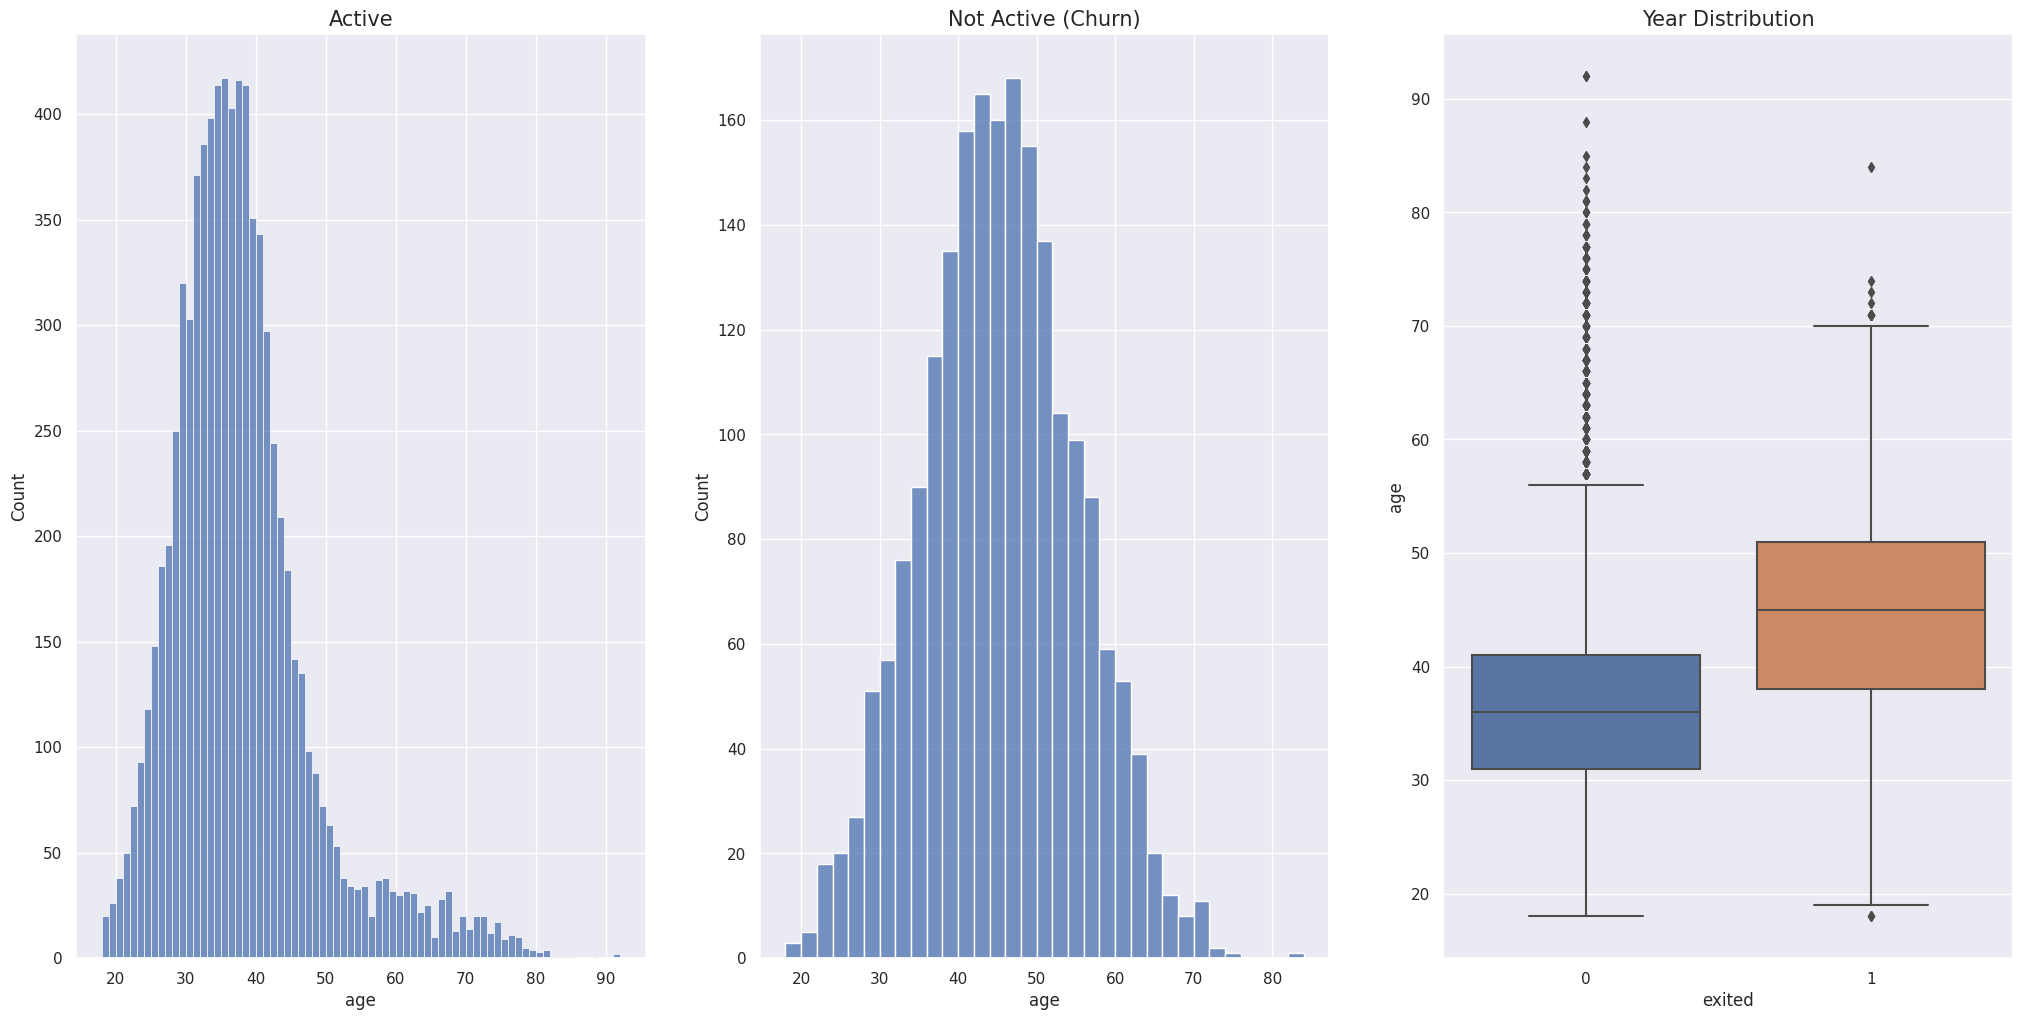

In [28]:
plt.subplot2grid((1,3),(0,0))
plt.subplot2grid((1,3),(0,1))
plt.subplot2grid((1,3),(0,2))

plt.subplot(1,3,1)
plt.title('Active', fontsize=15)
aux = df4[df4['exited']==0]
sns.histplot(aux, x='age');

plt.subplot(1,3,2)
plt.title('Not Active (Churn)', fontsize=15)
aux = df4[df4['exited']==1]
sns.histplot(aux, x='age');

plt.subplot(1,3,3)
plt.title('Year Distribution', fontsize=15)
sns.boxplot(df4, x='exited', y='age');

### H4.Clients who have the Top Bank's credit card are 10% less likely to churn.
    False -> There is no significant difference between the churn proportion of entries who have and do not have a credit card

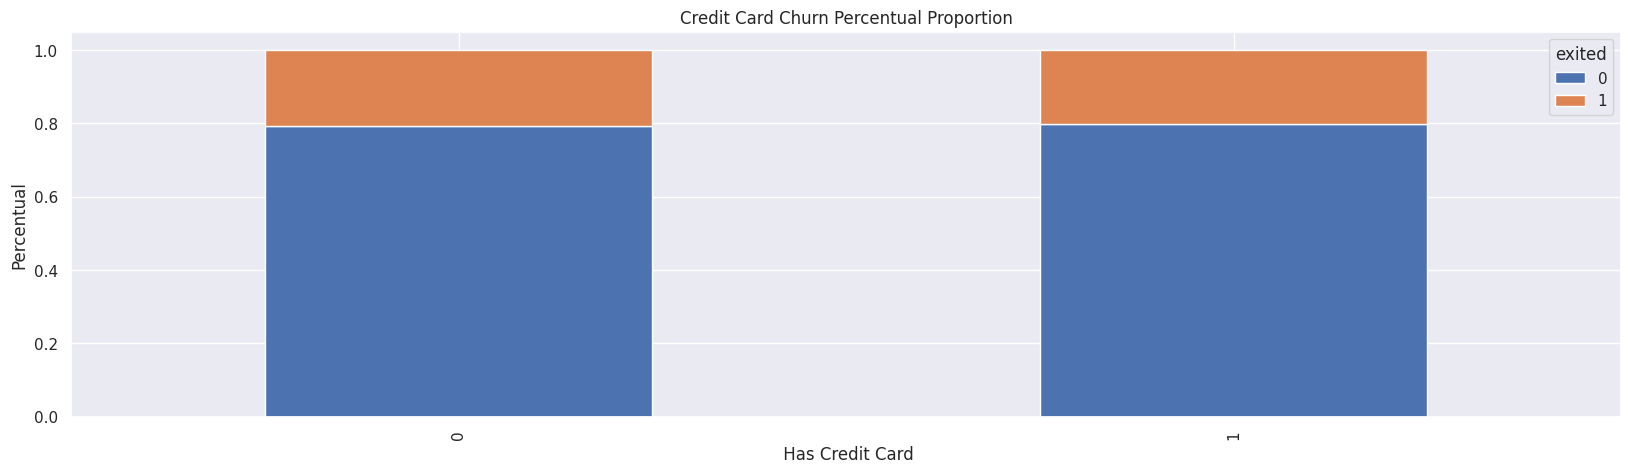

In [29]:
credit_aux = pd.crosstab(df4['has_cr_card'], df4['exited']).apply(lambda x: x/x.sum(), axis=1)
credit_aux.plot(kind='bar', stacked=True, xlabel=' Has Credit Card', ylabel='Percentual', title= 'Credit Card Churn Percentual Proportion', figsize=(20,5) );

### H5.Contracts with higher credit scores are 10% less likely to churn.
    False -> Central Tendency metrics (mean, median) present low variation between churn classes, according to credit score.

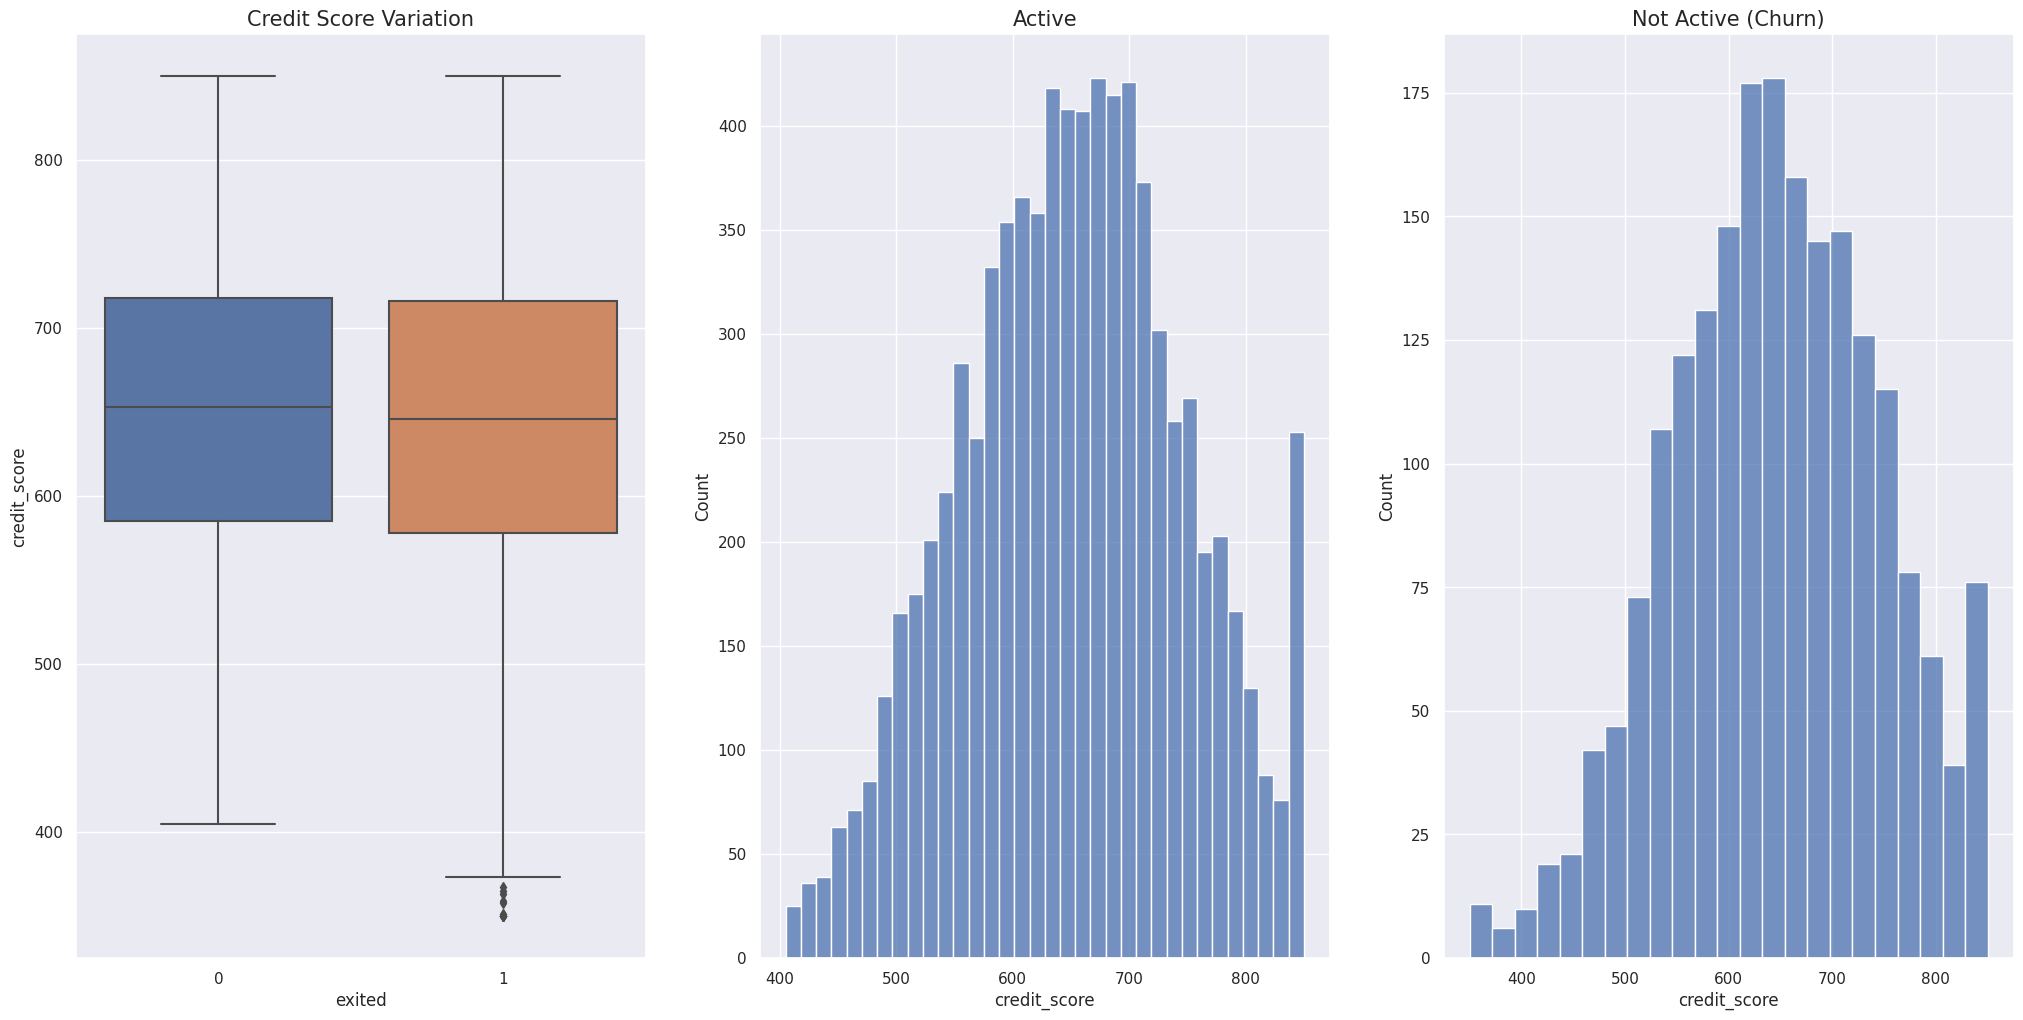

In [30]:
plt.subplot2grid((1,3), (0,0))
plt.subplot2grid((1,3), (0,1))
plt.subplot2grid((1,3), (0,2))

plt.subplot(1,3,1)
plt.title('Credit Score Variation', fontsize=15)
sns.boxplot(df4, x='exited', y='credit_score');

plt.subplot(1,3,2)
plt.title('Active', fontsize=15)
aux = df4[df4['exited'] == 0]
sns.histplot(aux, x='credit_score');

plt.subplot(1,3,3)
plt.title('Not Active (Churn)', fontsize=15)
aux = df4[df4['exited'] == 1]
sns.histplot(aux, x='credit_score');

### H6.Contracts with higher tenure values are 10% less likely to churn.
    False -> The proportion between churn classes present few variety according to tenure values.

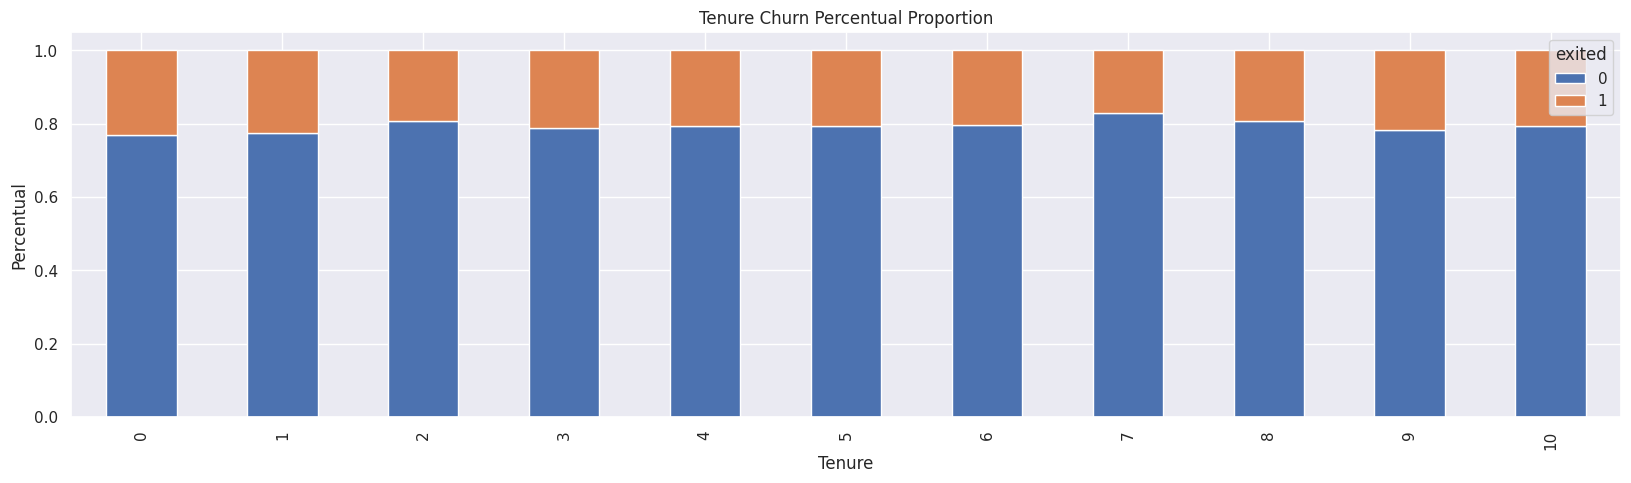

In [31]:
tenure_aux = pd.crosstab(df4['tenure'], df4['exited']).apply( lambda x: x/x.sum(), axis=1)
tenure_aux.plot(kind='bar', stacked=True, xlabel='Tenure', ylabel='Percentual', title='Tenure Churn Percentual Proportion', figsize=(20,5));

### H7.Contracts with higher inbank account balances are 10% less likely to churn.
    False -> Central Tendency metrics (mean, median) values have no significant variation between churning classes, according to balance metric.

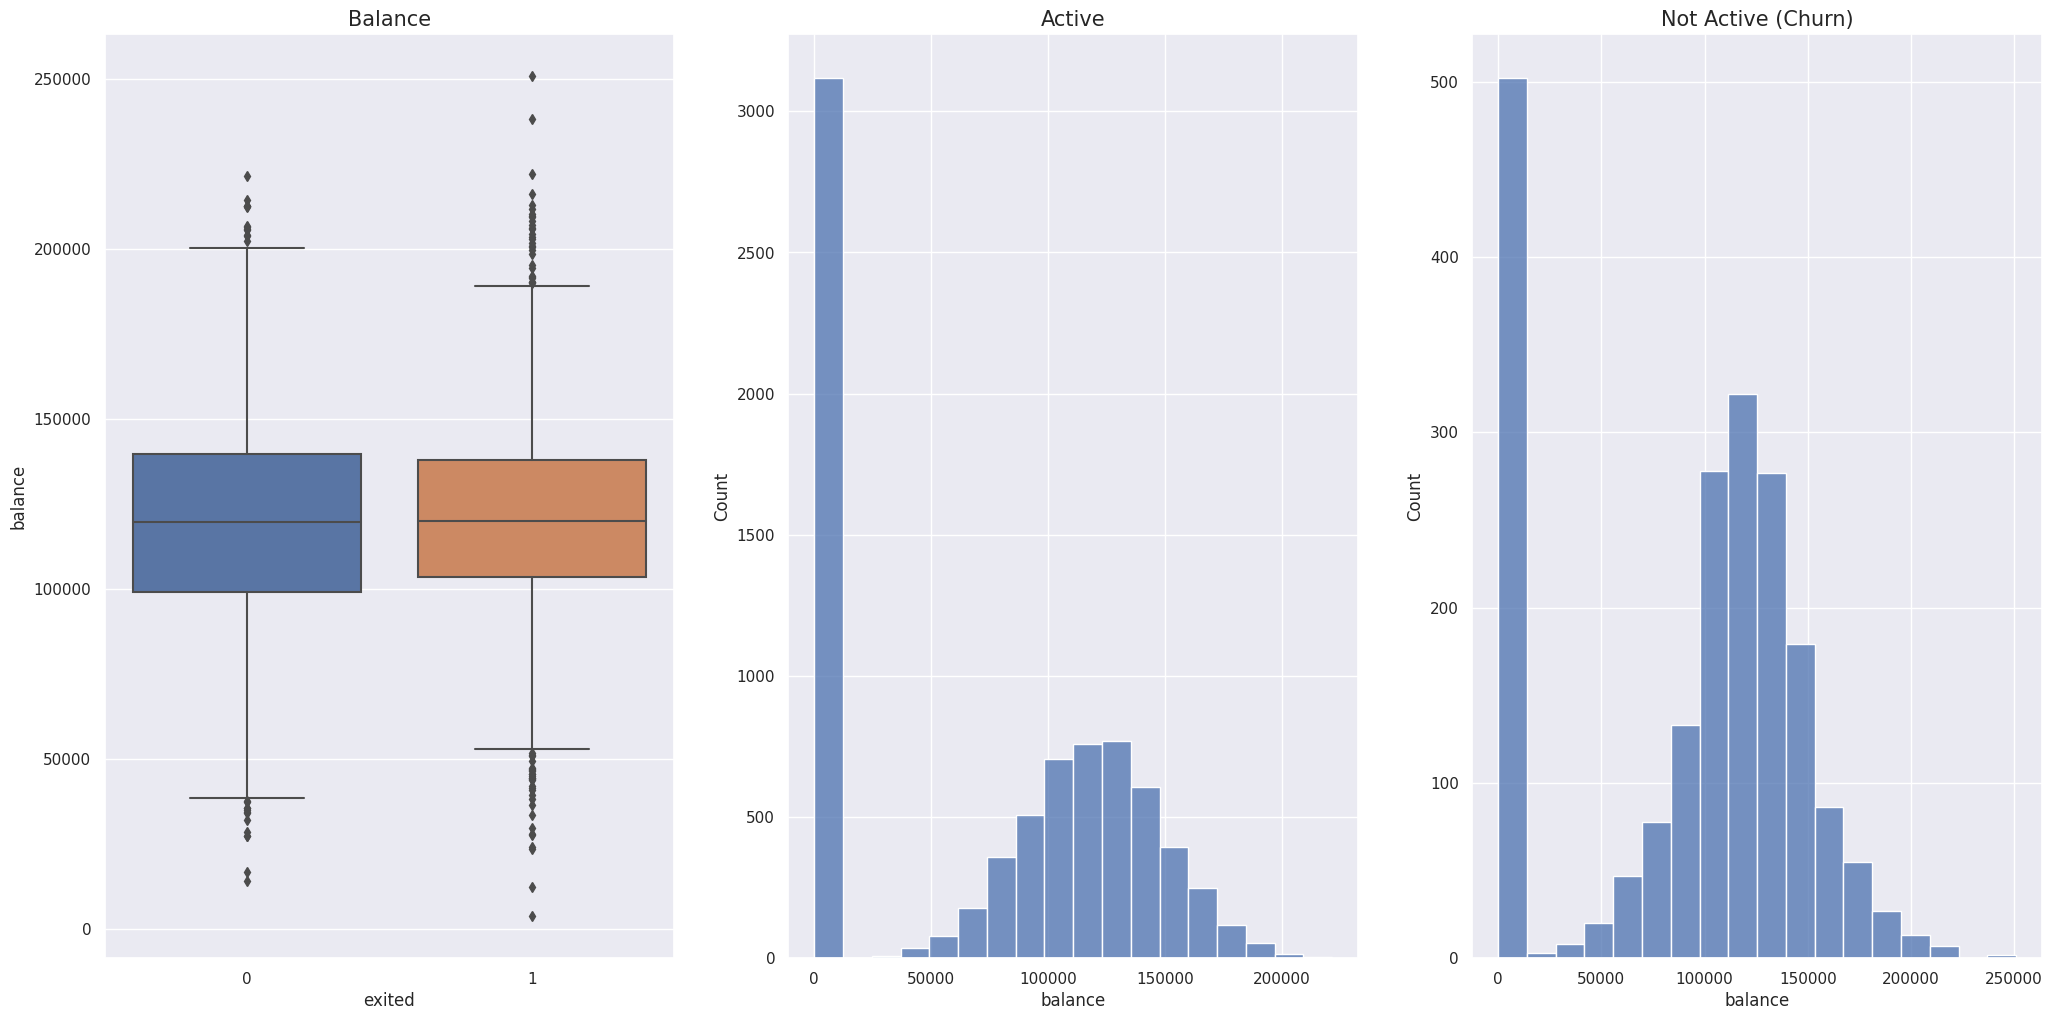

In [32]:
plt.subplot2grid((1,3), (0,0))
plt.subplot2grid((1,3), (0,1))
plt.subplot2grid((1,3), (0,2))

plt.subplot(1,3,1)
plt.title('Balance', fontsize=15)
aux = df4[df4['balance'] > 0]
sns.boxplot(aux, x='exited', y='balance');

plt.subplot(1,3,2)
plt.title('Active', fontsize=15)
aux = df4[df4['exited'] == 0]
sns.histplot(aux, x='balance');

plt.subplot(1,3,3)
plt.title('Not Active (Churn)', fontsize=15)
aux = df4[df4['exited'] == 1]
sns.histplot(aux, x='balance');

### H8.Contracts that present active situation under bank account movimentation are 10% less likely to churn.
    True -> Clients whose contract are inactive(low rate of inbank account movement) are aproximatelly 13% more likely to churn.

In [33]:
pd.crosstab(df4['is_active_member'], df4['exited']).apply(lambda x: x/x.sum(), axis=1)

exited,0,1
is_active_member,,
0,0.731491,0.268509
1,0.857309,0.142691


### H9.Contracts with higher estimated values for client salaries are 10% less likely to churn.
    False -> Distributions dont show any significant variation for churn classes, according to estimated salary values.

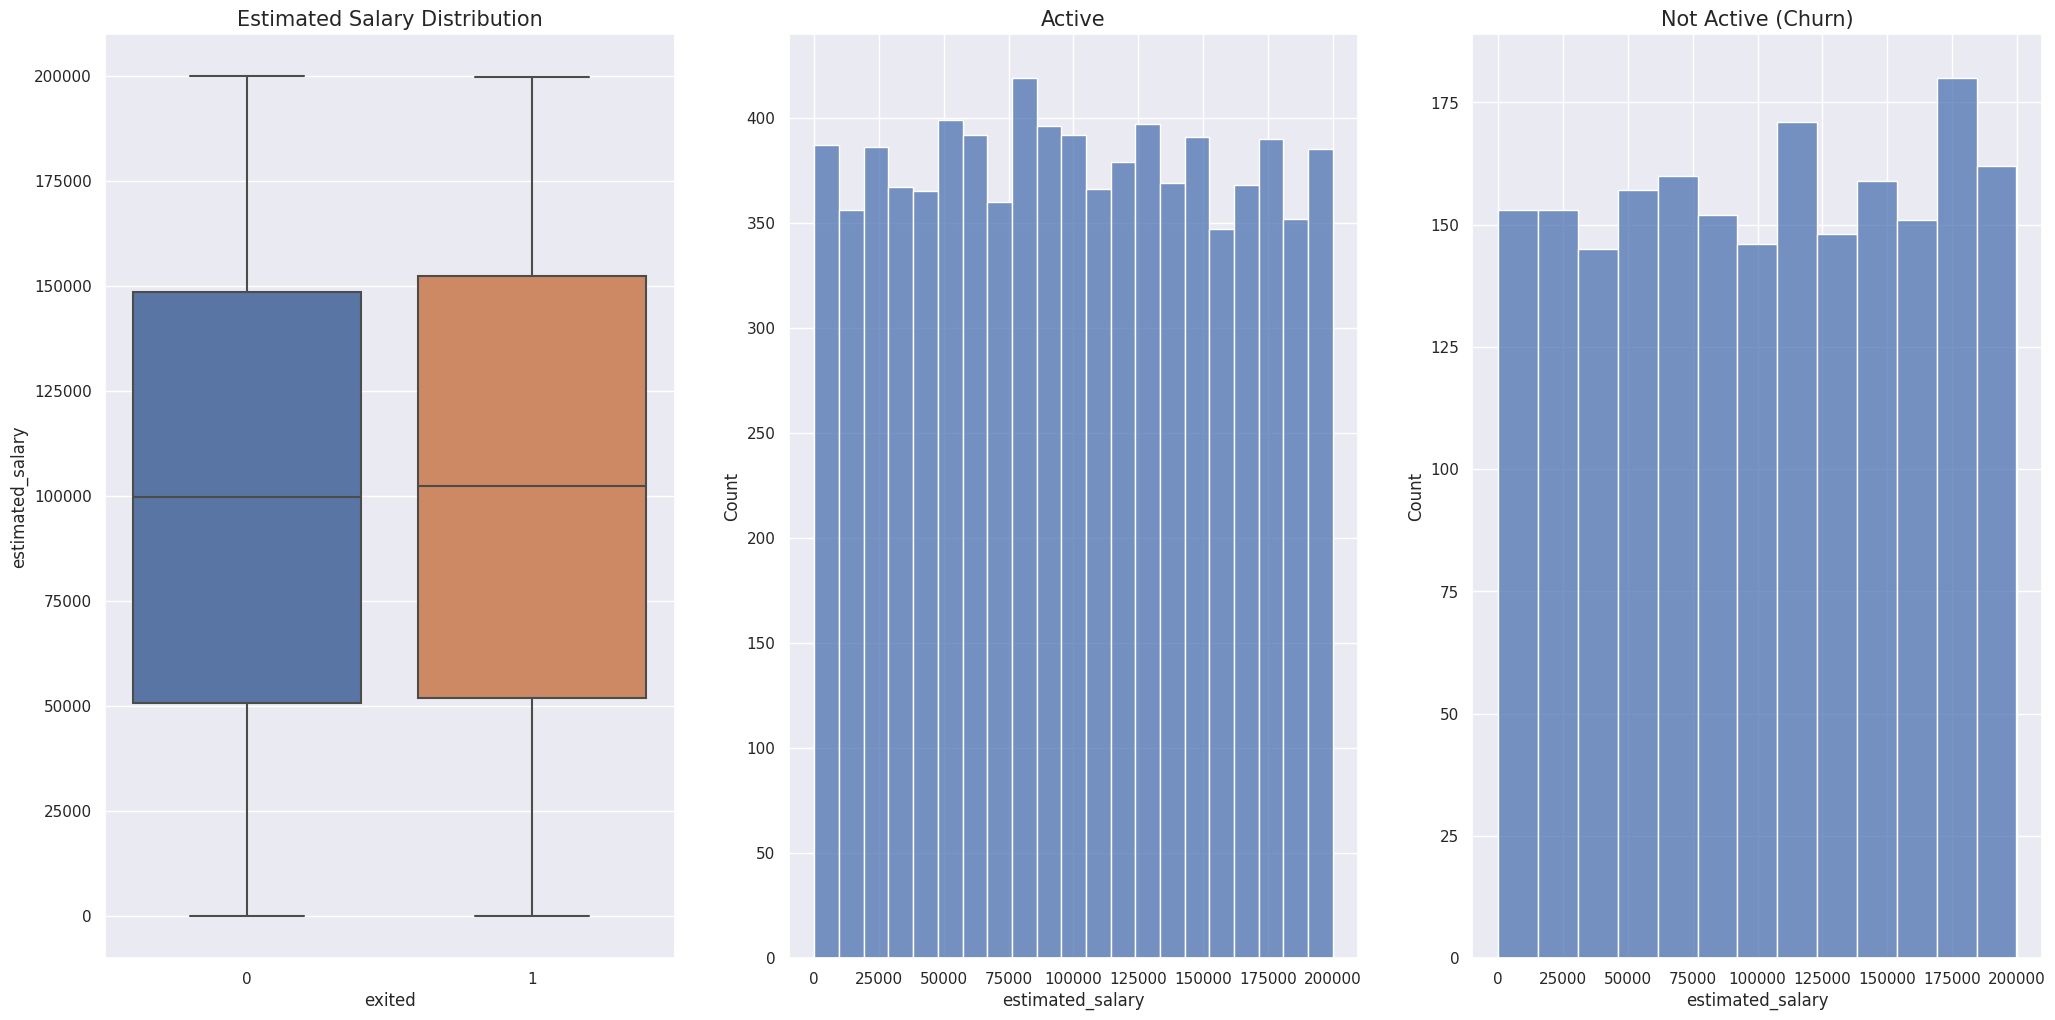

In [34]:
plt.subplot2grid((1,3), (0,0))
plt.subplot2grid((1,3), (0,1))
plt.subplot2grid((1,3), (0,2))

plt.subplot(1,3,1)
plt.title('Estimated Salary Distribution', fontsize=15)
sns.boxplot(df4, x='exited', y='estimated_salary');

plt.subplot(1,3,2)
plt.title('Active', fontsize=15)
aux = df4[df4['exited'] == 0]
sns.histplot(aux, x='estimated_salary');

plt.subplot(1,3,3)
plt.title('Not Active (Churn)', fontsize=15)
aux = df4[df4['exited'] == 1]
sns.histplot(aux, x='estimated_salary');

### H10.Contracts done with higher nº of used products tend to reduce up to 10% the chances of a client churn.
    True -> There is a larger proportion of churn amongst entries that has 1 product used.

In [35]:
pd.crosstab(df4['exited'], df4['num_of_products']).apply(lambda x: x/x.sum(), axis=1)

num_of_products,1,2,3,4
exited,,,,
0,0.461509,0.532714,0.005777,0.000000
1,0.691703,0.170839,0.108002,0.029455


### 4.2.2 EDA's Summary

In [36]:
from tabulate import tabulate

tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'True', 'High'], #Geography
       ['H2', 'True', 'High'], #Gender
       ['H3', 'True', 'High'], #Age
       ['H4', 'False', 'Low'], #has_cr_card
       ['H5', 'False', 'Low'], #credit_score
       ['H6', 'False', 'Low'], #tenure
       ['H7', 'False', 'Low'], #balance -> Note that there is a high proportion of people with balance '0' for both churned and not churned entries
       ['H8', 'True', 'High'], #is_active_member -> this reflect clients thar has more recency in Top Bank's database
       ['H9', 'False', 'Low'], #estimated_salary
       ['H10', 'True', 'High']] #num_of_products -> Entries with 1 product used are the vast majority of churn entries

print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            True          High
H2            True          High
H3            True          High
H4            False         Low
H5            False         Low
H6            False         Low
H7            False         Low
H8            True          High
H9            False         Low
H10           True          High


### 4.2.3 Feature Engineering (Bivariate Features)

*   The following features were created in order to further study patterns regarding features that had shown little relevance on EDA. This is done by combining features with each other

In [37]:
df4.head()

,row_number,geography,gender,age,has_cr_card,credit_score,tenure,balance,is_active_member,estimated_salary,num_of_products,exited
0,1,France,Female,42,1,619,2,0.00,1,101348.88,1,1
1,2,Spain,Female,41,0,608,1,83807.86,1,112542.58,1,0
2,3,France,Female,42,1,502,8,159660.80,0,113931.57,3,1
3,4,France,Female,39,0,699,1,0.00,0,93826.63,2,0
4,5,Spain,Female,43,1,850,2,125510.82,1,79084.10,1,0


In [38]:
#credit_score_age
df4['credit_score_age'] = df4['credit_score']*df4['age']

#credit_score_salary
df4['credit_score_salary'] = df4['credit_score']*df4['estimated_salary']

#tenure_age
df4['tenure_age'] = df4['age']*df4['tenure']

#tenure_credit_score
df4['tenure_cr_score'] = df4['credit_score']*df4['tenure']

#tenure_balance
df4['tenure_balance'] = df4['balance']*df4['tenure']

#balance per salary
df4['balance_per_salary'] = df4['balance']/df4['estimated_salary']

#Product utilization rate by year(tenure)
df4['product_rate_year'] = df4.apply(lambda row: 1 if (row['tenure'] == 0) else row['num_of_products']/row['tenure'], axis = 1)

#Product utilization rate by estimated salary
df4['product_rate_salary'] = df4.apply(lambda row: 0 if (row['num_of_products'] == 0) else row['num_of_products']/row['estimated_salary'], axis = 1)



reorder_columns = ['row_number', 'geography', 'gender', 'age', 'has_cr_card',
       'credit_score', 'tenure', 'balance', 'is_active_member',
       'estimated_salary', 'num_of_products', 'credit_score_age', 'credit_score_salary',
       'tenure_age', 'tenure_cr_score', 'tenure_balance', 
       'balance_per_salary','product_rate_year' , 'product_rate_salary',
       'exited']

df4 = df4.reindex(columns=reorder_columns) 

In [39]:
df4.head()

,row_number,geography,gender,age,has_cr_card,credit_score,tenure,balance,is_active_member,estimated_salary,num_of_products,credit_score_age,credit_score_salary,tenure_age,tenure_cr_score,tenure_balance,balance_per_salary,product_rate_year,product_rate_salary,exited
0,1,France,Female,42,1,619,2,0.00,1,101348.88,1,25998,62734956.72,84,1238,0.00,0.000000,0.500,0.000010,1
1,2,Spain,Female,41,0,608,1,83807.86,1,112542.58,1,24928,68425888.64,41,608,83807.86,0.744677,1.000,0.000009,0
2,3,France,Female,42,1,502,8,159660.80,0,113931.57,3,21084,57193648.14,336,4016,1277286.40,1.401375,0.375,0.000026,1
3,4,France,Female,39,0,699,1,0.00,0,93826.63,2,27261,65584814.37,39,699,0.00,0.000000,2.000,0.000021,0
4,5,Spain,Female,43,1,850,2,125510.82,1,79084.10,1,36550,67221485.00,86,1700,251021.64,1.587055,0.500,0.000013,0


## 4.3 Multivariative Analysis

### 4.3.1 Numerical Variables

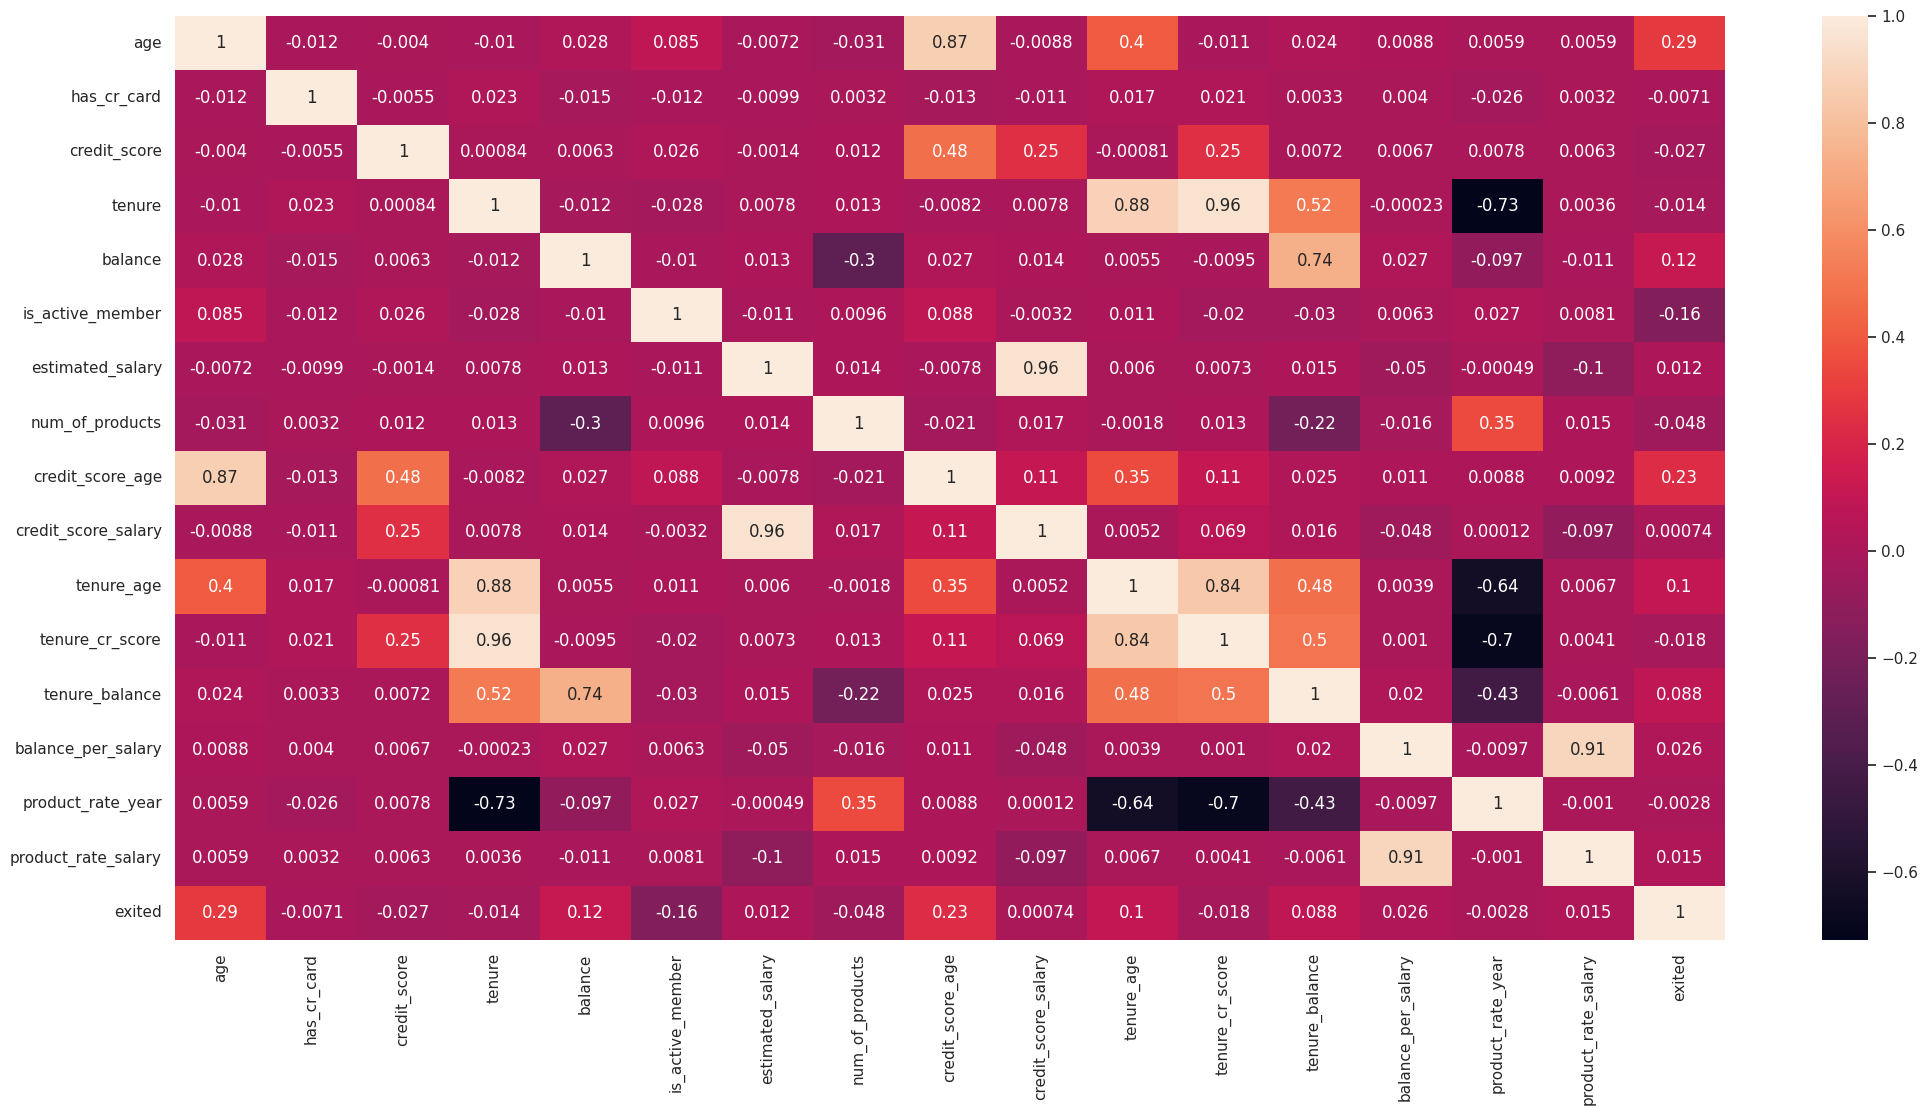

In [40]:
df4_num = df4.select_dtypes(include=['int64', 'float64'])

aux_cor = df4_num.drop('row_number', axis=1)
correlation = aux_cor.corr(method='pearson')
sns.heatmap(correlation, annot=True);

*   By multivariative Analysis, we have not obtained significant corelation between feature engineered variables and our class variable.

### 4.3.2 Categorical Variables

Else condition Met:  1.0
Else condition Met:  0.022177582131597692
Else condition Met:  0.022177582131597692
Else condition Met:  0.9997982949581297


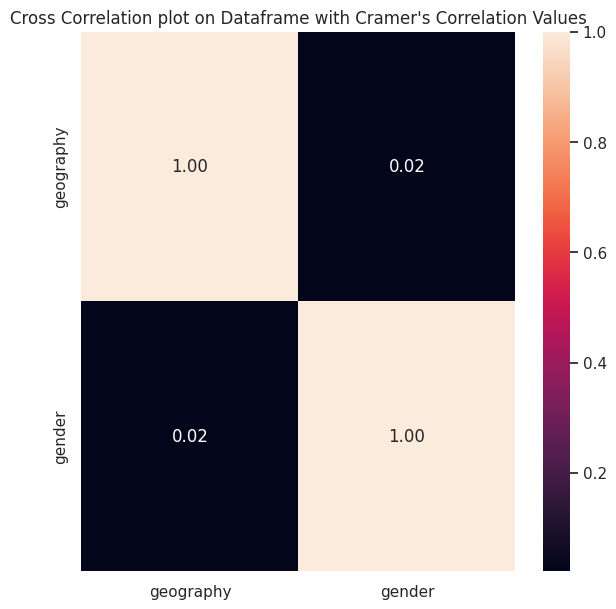

In [41]:
df4_cat = df4.select_dtypes(include='object')
plot_cramer(df4_cat)

* By Cramer-V corelation, we can conclude that gender does not have a relation with originary country (Value close to 0)

# 5.0 DATA PREPARATION

In [42]:
df5 = df4.copy()

In [43]:
x_split = df5.drop(['row_number','exited'], axis=1)
y_split = df5['exited'].copy()

X_train, X_validation, y_train, y_validation = train_test_split(x_split, y_split, test_size=0.2, random_state = 32)

df5 = pd.concat([X_train, y_train], axis=1)
df5 = df5.reset_index(drop=True)

In [44]:
df5.head()

,geography,gender,age,has_cr_card,credit_score,tenure,balance,is_active_member,estimated_salary,num_of_products,credit_score_age,credit_score_salary,tenure_age,tenure_cr_score,tenure_balance,balance_per_salary,product_rate_year,product_rate_salary,exited
0,Spain,Female,41,0,530,4,0.00,1,147606.71,2,21730,78231556.30,164,2120,0.00,0.000000,0.500000,0.000014,0
1,France,Female,40,1,618,0,0.00,0,119059.13,1,24720,73578542.34,0,0,0.00,0.000000,1.000000,0.000008,0
2,France,Female,59,1,713,3,0.00,1,62700.08,2,42067,44705157.04,177,2139,0.00,0.000000,0.666667,0.000032,0
3,Spain,Female,35,1,461,8,0.00,0,132295.95,1,16135,60988432.95,280,3688,0.00,0.000000,0.125000,0.000008,0
4,Germany,Male,32,1,758,4,162657.64,1,115525.13,2,24256,87568048.54,128,3032,650630.56,1.407985,0.500000,0.000017,0


## 5.1 Standardization

In [45]:
ss_credit_score            = StandardScaler()
ss_tenure                  = StandardScaler()
ss_balance                 = StandardScaler()
ss_credit_score_age        = StandardScaler()
ss_credit_score_salary     = StandardScaler()
ss_tenure_age              = StandardScaler()
ss_tenure_cr_score         = StandardScaler()
ss_tenure_balance          = StandardScaler()
ss_balance_per_salary      = StandardScaler()
ss_product_rate_year       = StandardScaler()

#credit_score
df5['credit_score'] = ss_credit_score.fit_transform(df5[['credit_score']].values)

#tenure
df5['tenure'] = ss_tenure.fit_transform(df5[['tenure']].values)

#balance
df5['balance'] = ss_balance.fit_transform(df5[['balance']].values)

#credit_score_age
df5['credit_score_age'] = ss_credit_score_age.fit_transform(df5[['credit_score_age']].values)

#credit_score_salary
df5['credit_score_salary'] = ss_credit_score_salary.fit_transform(df5[['credit_score_salary']].values)

#tenure_age
df5['tenure_age'] = ss_tenure_age.fit_transform(df5[['tenure_age']].values)

#tenure_cr_score
df5['tenure_cr_score'] = ss_tenure_cr_score.fit_transform(df5[['tenure_cr_score']].values)

#tenure_balance
df5['tenure_balance'] = ss_tenure_balance.fit_transform(df5[['tenure_balance']].values)

#balance_salary
df5['balance_per_salary'] = ss_balance_per_salary.fit_transform(df5[['balance_per_salary']].values)

#product_rate_year
df5['product_rate_year'] = ss_product_rate_year.fit_transform(df5[['product_rate_year']].values)

## 5.2 Normalization (Reescaling)

In [46]:
mms_age                 = MinMaxScaler()
mms_estimated_salary    = MinMaxScaler()
mms_product_rate_salary = MinMaxScaler()

#age
df5['age'] = mms_age.fit_transform(df5[['age']].values)

#estimated_salary
df5['estimated_salary'] = mms_estimated_salary.fit_transform(df5[['estimated_salary']].values)

#product_rate_salary
df5['product_rate_salary'] = mms_product_rate_salary.fit_transform(df5[['product_rate_salary']].values)

## 5.3 Encoding

In [47]:
#geography - Mean Target Encoding
te_geography = df5.groupby('geography')['exited'].mean()
df5.loc[:, 'geography'] = df5['geography'].map(te_geography)

#gender - Mean Target Encoding
te_gender = df5.groupby('gender')['exited'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(te_gender)

In [48]:
X_validation['gender'].head()

5097      Male
2580    Female
260       Male
6781    Female
5468      Male
Name: gender, dtype: object

In [49]:
df5.head()

,geography,gender,age,has_cr_card,credit_score,tenure,balance,is_active_member,estimated_salary,num_of_products,credit_score_age,credit_score_salary,tenure_age,tenure_cr_score,tenure_balance,balance_per_salary,product_rate_year,product_rate_salary,exited
0,0.166166,0.246609,0.310811,0,-1.249558,-0.346947,-1.225139,1,0.738046,2,-0.456814,0.336810,-0.239529,-0.577053,-0.898759,-0.033959,0.013964,0.000099,0
1,0.159849,0.246609,0.297297,1,-0.337299,-1.727317,-1.225139,0,0.595295,1,-0.076482,0.217921,-1.515378,-1.653611,-0.898759,-0.033959,1.073354,0.000039,0
2,0.159849,0.246609,0.554054,1,0.647527,-0.692040,-1.225139,1,0.313472,2,2.130076,-0.519828,-0.138395,-0.567405,-0.898759,-0.033959,0.367094,0.000311,0
3,0.166166,0.246609,0.229730,1,-1.964852,1.033422,-1.225139,0,0.661485,1,-1.168504,-0.103771,0.662901,0.219193,-0.898759,-0.033959,-0.780579,0.000030,0
4,0.322757,0.166173,0.189189,1,1.114023,-0.346947,1.381996,1,0.577623,2,-0.135504,0.575369,-0.519593,-0.113930,0.648423,-0.022296,0.013964,0.000143,0


## 5.4 Validation Preparation

In [50]:
#geography
X_validation.loc[:, 'geography'] = X_validation.loc[:, 'geography'].map(te_geography)

#gender
X_validation.loc[:, 'gender'] = X_validation.loc[:, 'gender'].map(te_gender)

#age
X_validation.loc[:, 'age'] = mms_age.transform(X_validation[['age']].values)

#credit_score
X_validation.loc[:, 'credit_score'] = ss_credit_score.transform(X_validation[['credit_score']].values)

#tenure
X_validation.loc[:, 'tenure'] = ss_tenure.transform(X_validation[['tenure']].values)

#balance
X_validation.loc[:, 'balance'] = ss_balance.transform(X_validation[['balance']].values)

#estimated_salary
X_validation.loc[:, 'estimated_salary'] = mms_estimated_salary.transform(X_validation[['estimated_salary']].values)

#credit_score_age
X_validation.loc[:, 'credit_score_age'] = ss_credit_score_age.transform(X_validation[['credit_score_age']].values)

#credit_score_salary
X_validation.loc[:, 'credit_score_salary'] = ss_credit_score_salary.transform(X_validation[['credit_score_salary']].values)

#tenure_age
X_validation.loc[:, 'tenure_age'] = ss_tenure_age.transform(X_validation[['tenure_age']].values)

#tenure_cr_score
X_validation.loc[:, 'tenure_cr_score'] = ss_tenure_cr_score.transform(X_validation[['tenure_cr_score']].values)

#tenure_balance
X_validation.loc[:, 'tenure_balance'] = ss_tenure_balance.transform(X_validation[['tenure_balance']].values)

#balance_per_salary
X_validation.loc[:, 'balance_per_salary'] = ss_balance_per_salary.transform(X_validation[['balance_per_salary']].values)

#product_rate_year
X_validation.loc[:, 'product_rate_year'] = ss_product_rate_year.transform(X_validation[['product_rate_year']].values)

#product_rate_salary
X_validation.loc[:, 'product_rate_salary'] = mms_product_rate_salary.transform(X_validation[['product_rate_salary']].values)

In [51]:
X_validation.isna().sum()

geography              0
gender                 0
age                    0
has_cr_card            0
credit_score           0
tenure                 0
balance                0
is_active_member       0
estimated_salary       0
num_of_products        0
credit_score_age       0
credit_score_salary    0
tenure_age             0
tenure_cr_score        0
tenure_balance         0
balance_per_salary     0
product_rate_year      0
product_rate_salary    0
dtype: int64

In [52]:
X_validation.head()

,geography,gender,age,has_cr_card,credit_score,tenure,balance,is_active_member,estimated_salary,num_of_products,credit_score_age,credit_score_salary,tenure_age,tenure_cr_score,tenure_balance,balance_per_salary,product_rate_year,product_rate_salary
5097,0.166166,0.166173,0.027027,1,-0.005568,1.033422,-1.225139,1,0.567345,2,-1.567279,0.222436,-0.270647,0.987003,-0.898759,-0.033959,-0.515731,0.000146
2580,0.322757,0.246609,0.270270,1,0.481661,0.343238,0.900083,1,0.036885,1,0.148155,-1.530525,0.258363,0.470052,0.993033,0.114711,-0.692296,0.001510
260,0.322757,0.166173,0.324324,1,0.844492,1.378515,0.517914,1,0.326589,2,0.689777,-0.440329,1.425298,1.691844,1.428641,-0.020169,-0.574586,0.000297
6781,0.159849,0.246609,0.324324,1,2.067748,-0.692040,-1.225139,1,0.884444,2,1.320186,2.179543,-0.535152,-0.358695,-0.898759,-0.033959,0.367094,0.000073
5468,0.159849,0.166173,0.364865,1,-0.617197,-0.001855,-1.225139,1,0.777481,2,0.162020,0.685960,0.235025,-0.153032,-0.898759,-0.033959,-0.197914,0.000091


# 6.0 FEATURE SELECTION

In [53]:
df6 = df5.copy()

## 6.1 Train-Test Split

In [54]:
training_data, testing_data = X_train, X_validation

print(f'No. of training examples:{training_data.shape[0]}')
print(f'No. of testing examples:{testing_data.shape[0]}')

No. of training examples:8000
No. of testing examples:2000


## 6.2 Feature Selection (w/ Random Forest)

In [55]:
x_train_n = df6.drop('exited', axis=1)
y_train_n = y_train.values

#Define Extra Trees Classifier
rf = ExtraTreesClassifier(n_estimators=250, random_state=32, n_jobs=-1)
rf.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=32)

Feature Ranking:
               feature  importance
0                  age    0.130578
0      num_of_products    0.118347
0     credit_score_age    0.087223
0           tenure_age    0.058749
0              balance    0.058629
0         credit_score    0.057448
0     estimated_salary    0.049954
0      tenure_cr_score    0.049699
0  credit_score_salary    0.049306
0  product_rate_salary    0.049278
0            geography    0.045326
0       tenure_balance    0.044344
0    product_rate_year    0.044015
0   balance_per_salary    0.039670
0     is_active_member    0.038196
0               tenure    0.037345
0          has_cr_card    0.023096
0               gender    0.018797


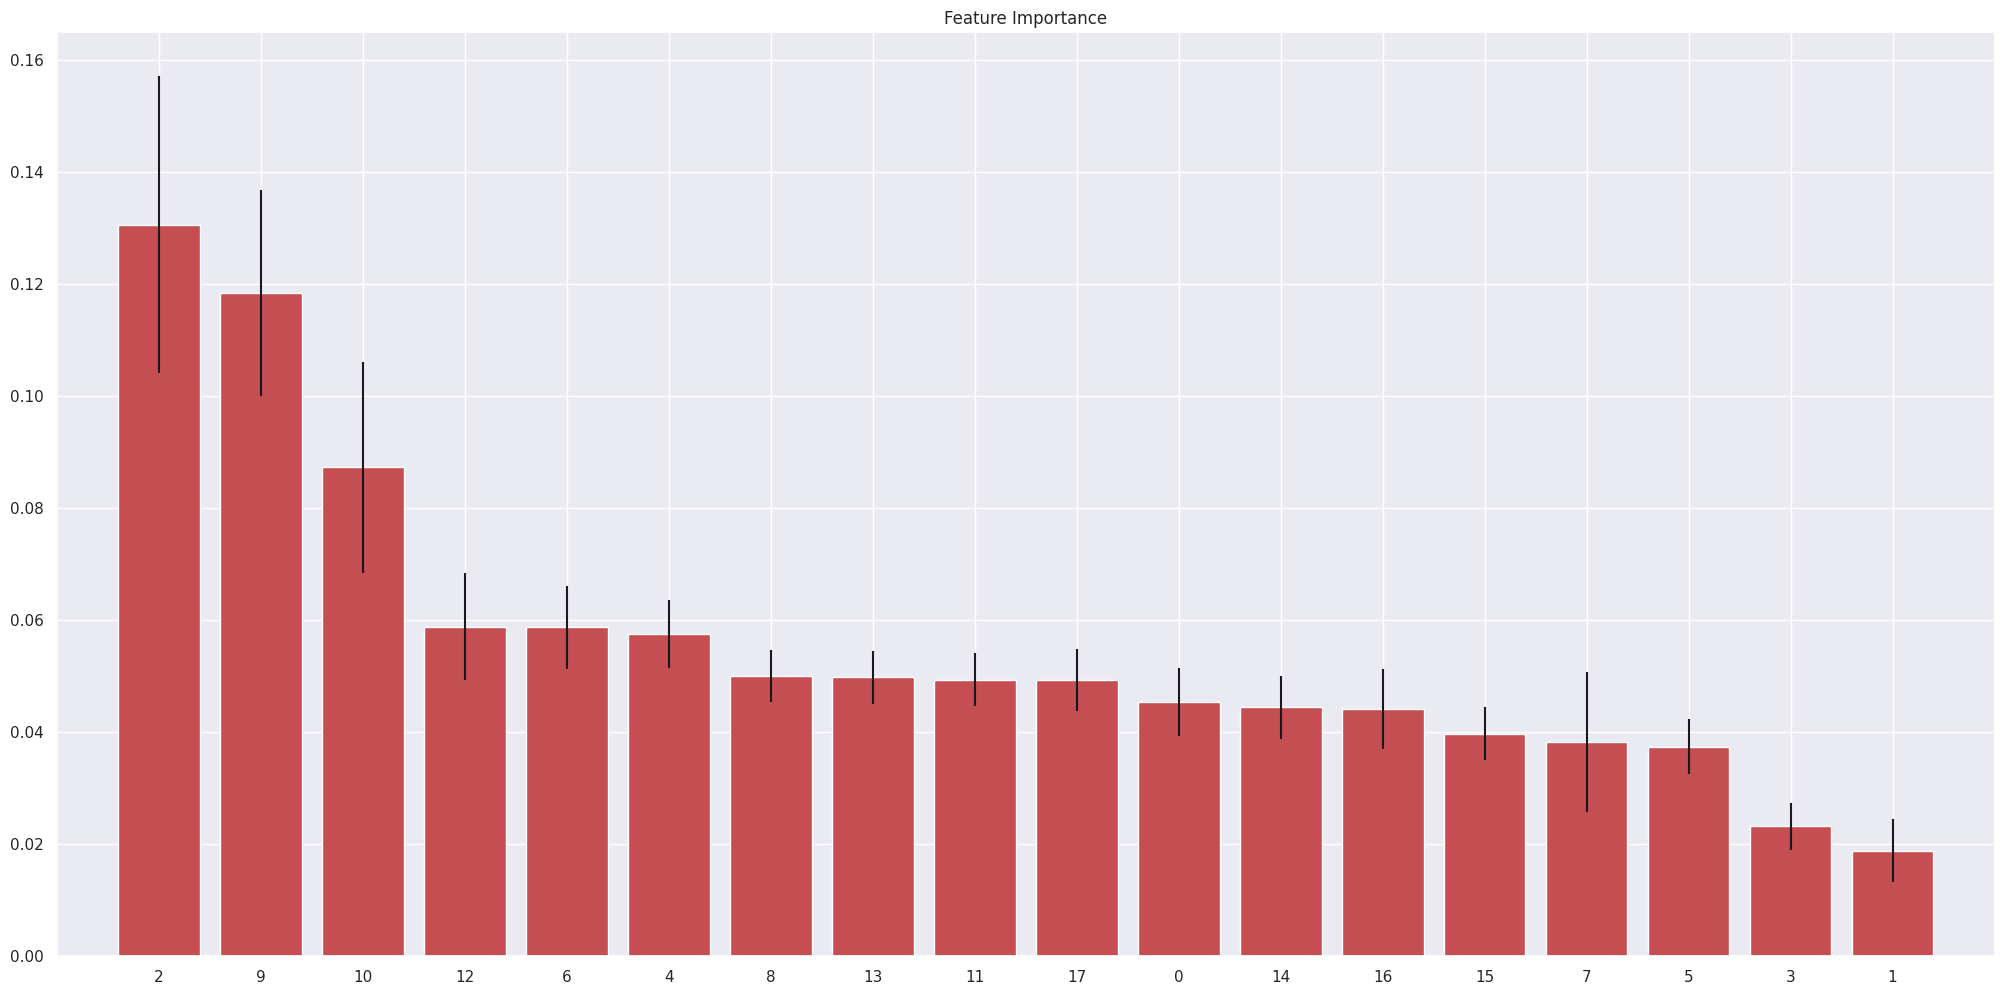

In [56]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

#Print the Feature Ranking
print('Feature Ranking:')
df = pd.DataFrame()
for i, j in zip(x_train_n, rf.feature_importances_):
    aux_imp = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux_imp], axis=0)

print(df.sort_values('importance', ascending=False))

#Plot the Impurity based feature importance target
plt.figure()
plt.title('Feature Importance')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

## 6.3 Feature Selection (w/Boruta)

In [57]:
x_train_n = df6.drop('exited', axis=1).values
y_train_n = y_train.values.ravel()

rf = RandomForestRegressor(n_jobs=-1)

boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=32).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	14


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	14


In [59]:
cols_selected = boruta.support_.tolist()

x_train_fs = X_train
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

In [61]:
cols_selected_boruta

['age', 'balance', 'is_active_member', 'num_of_products']

### Summing up the features chosen:

*   By EDA: geography, gender, age, is_active_member, num_of_products
*   By Feature Selection (w/Random Forest): age, num_of_products, credit_score_age, tenure_age, balance, credit_score, estimated_salary, tenure_cr_score, credit_score_salary, product_rate_salary
*   By Feature Selection (w/ Boruta): age, balance, is_active_member, num_of_products

*   Summarizing the total of features: geography, gender, age, is_active_member, num_of_products, credit_score_age, tenure_age, balance, credit_score, estimated_salary, tenure_cr_score, credit_score_salary, product_rate_salary